In [3]:
import snowflake.connector
import pandas as pd

from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

CONEXÃO

In [4]:
from dotenv import load_dotenv
import os

load_dotenv('config.env')

user = os.getenv('user')
password = os.getenv('password')
account = os.getenv('account')
warehouse = os.getenv('warehouse')
database = os.getenv('database')
schema = os.getenv('schema')

In [5]:
conn = snowflake.connector.connect(
    user=user
    , password=password
    , account=account 
    , warehouse=warehouse
    , database=database   
    , schema=schema       
)

In [3]:
cursor = conn.cursor()

In [ ]:
cursor.close()
conn.close()

CARREGAR OS DADOS

In [4]:
query = """SELECT 
            NM_CLIENTE
            , NOME_PRODUTO
            , ANO
            , MES
            , DATA_REF
            , QUANTIDADE
            , REGIAO
        from agg_sales_store """

cursor.execute(query)
rows = cursor.fetchall()

columns = [desc[0] for desc in cursor.description]
df_cliente = pd.DataFrame(rows, columns=columns)

print(df_cliente.head(100))

           NM_CLIENTE        NOME_PRODUTO   ANO  MES    DATA_REF  QUANTIDADE  \
0   Extreme Toy Store        Front Brakes  2013   12  2013-12-01           1   
1   Extreme Toy Store   HL Bottom Bracket  2013   12  2013-12-01           2   
2   Extreme Toy Store   HL Bottom Bracket  2014    3  2014-03-01           1   
3   Extreme Toy Store   HL Mountain Pedal  2013    6  2013-06-01           2   
4   Extreme Toy Store         LL Crankset  2013    9  2013-09-01           1   
..                ...                 ...   ...  ...         ...         ...   
95  First Cycle Store  Road-250 Black, 48  2014    5  2014-05-01           3   
96  First Cycle Store  Road-250 Black, 52  2013    7  2013-07-01           1   
97  First Cycle Store  Road-250 Black, 52  2013   10  2013-10-01           1   
98  First Cycle Store  Road-250 Black, 52  2014    5  2014-05-01           4   
99  First Cycle Store  Road-250 Black, 58  2013    7  2013-07-01           1   

     REGIAO  
0   Alabama  
1   Alabama

PREPARAR OS DADOS

In [6]:
df_cliente['DATA_REF'] = pd.to_datetime(df_cliente['DATA_REF'])
df_grouped = df_cliente.groupby(['NOME_PRODUTO', 'DATA_REF'])['QUANTIDADE'].sum().reset_index()

produto_teste = 'HL Bottom Bracket'
df_produto = df_grouped[df_grouped['NOME_PRODUTO'] == produto_teste]


df_produto.set_index('DATA_REF', inplace=True)
df_produto = df_produto.asfreq('MS')
df_produto.dropna(subset=['QUANTIDADE'], inplace=True)

y = df_produto['QUANTIDADE']

# Dividir em treino (80%) e teste (20%)
train_size = int(len(y) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]
t_train, t_test = np.arange(len(y_train)), np.arange(len(y_test))



REGRESSÃO LINEAR

In [7]:
X_train = t_train.reshape(-1, 1)
X_test = t_test.reshape(-1, 1)


reg_model = LinearRegression()
reg_model.fit(X_train, y_train)


y_reg_pred = reg_model.predict(X_test)

ARIMA

In [8]:
arima_model = ARIMA(y_train, order=(0, 1, 1))
arima_fit = arima_model.fit()


y_arima_pred = arima_fit.forecast(steps=len(y_test))

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


MÉTRICAS DE ERRO

In [9]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


rmse_reg = np.sqrt(mean_squared_error(y_test, y_reg_pred))
mae_reg = mean_absolute_error(y_test, y_reg_pred)
mape_reg = mean_absolute_percentage_error(y_test, y_reg_pred)


rmse_arima = np.sqrt(mean_squared_error(y_test, y_arima_pred))
mae_arima = mean_absolute_error(y_test, y_arima_pred)
mape_arima = mean_absolute_percentage_error(y_test, y_arima_pred)


print(f"Modelo de Regressão Linear para {produto_teste}:")
print(f"RMSE: {rmse_reg:.2f}, MAE: {mae_reg:.2f}, MAPE: {mape_reg:.2f}%\n")

print(f"Modelo ARIMA para {produto_teste}:")
print(f"RMSE: {rmse_arima:.2f}, MAE: {mae_arima:.2f}, MAPE: {mape_arima:.2f}%\n")

Modelo de Regressão Linear para HL Bottom Bracket:
RMSE: 16.12, MAE: 12.71, MAPE: 21.54%

Modelo ARIMA para HL Bottom Bracket:
RMSE: 16.82, MAE: 12.75, MAPE: 10.70%



PLOTAGEM

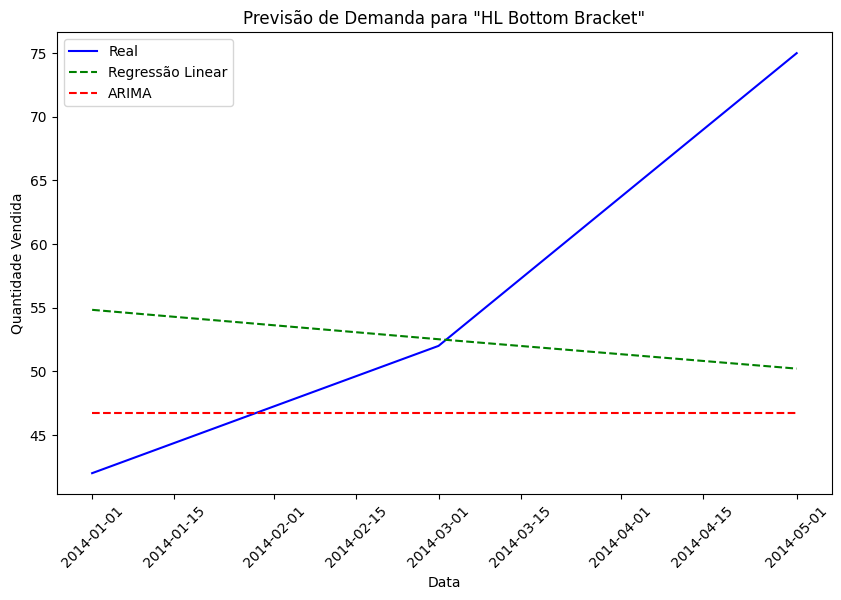

In [10]:

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Real', color='blue')
plt.plot(y_test.index, y_reg_pred, label='Regressão Linear', color='green', linestyle='dashed')
plt.plot(y_test.index, y_arima_pred, label='ARIMA', color='red', linestyle='dashed')
plt.legend()
plt.title(f'Previsão de Demanda para "HL Bottom Bracket"')
plt.xlabel('Data')
plt.ylabel('Quantidade Vendida')
plt.xticks(rotation=45)

plt.savefig('9-regressao_linear.png', bbox_inches='tight')

plt.show()